# ПРОЕКТ

# Побудова моделі для прогнозування кількості покупок клієнтів щодо різних продуктів, що в майбутньому допоможе створити персоналізовану пропозицію для клієнтів щодо різних продуктів.

## >Використані бібліотеки

In [127]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score as r2, \
                            mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            mean_absolute_percentage_error as mape
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb


## >Вибір даних 

_Обрано готовий набір даних за посиланням
https://www.kaggle.com/datasets/rishikeshkonapure/black-friday-sales-eda.    
Таким чином, отримав файл "train.csv"._

In [128]:
black_friday = pd.read_csv('train.csv')

## >Попередня обробка даних

### Перевірка основної статистики набору даних

In [129]:
black_friday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


_Швидкий аналіз стовпців:  
User_ID  - Ідентифікатор користувача  
Product_ID - Ідентифікатор продукту  
Gender - Стать користувача  
Age - Вік у діапазонах  
Occupation -  Професія (в масках)  
City_Category - Категорія міста (A,B,C)  
Stay In Current City Years - Кількість років перебування в поточному місті  
Marital_Status - Сімейний стан  
Product Category 1 - Категорія продукту (замаскована)  
Product Category 2 - Продукт також може належати до іншої категорії (замаскований)  
Product Category 3 - Продукт також може належати до іншої категорії (замаскований)  
Purchase - Сума покупки (цільова змінна, яка буде прогнозуватись)_

In [130]:
black_friday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


_Бачимо, що дані містять 12 колонок і 550068 рядків.  
Є пропущені значення у деяких стовпчиках, 2 стопці у формаі float64, 5 стовпців в int64, 5 стовпців в object._

#### Виведення пропущених значень у відсотках  

In [131]:
black_friday.isna().sum().div(black_friday.shape[0]).mul(100).round(2)

User_ID                        0.00
Product_ID                     0.00
Gender                         0.00
Age                            0.00
Occupation                     0.00
City_Category                  0.00
Stay_In_Current_City_Years     0.00
Marital_Status                 0.00
Product_Category_1             0.00
Product_Category_2            31.57
Product_Category_3            69.67
Purchase                       0.00
dtype: float64

_Бачимо, що "Продукт категорії 3" має майже 70% пропусків, що вказує на те, що ця колонка нам може бути і не потрібна, оскільки 
її значення особливо не вплинуть на наш прогноз.  
Колонка "Продукт категорії 2", що моє трохи більше 31% пропусків, вказує на те, що потрібно буде з нею щось зробити в майбутньому._

#### Відкидання не інформативних колонок

In [132]:
black_friday.drop(columns=['User_ID' , 'Product_ID'], inplace=True)

_Колонки 'User_ID' та 'Product_ID' є неінформативними, тому іх видаляємо._

#### Виведення основних показників 

In [133]:
black_friday.describe().T

,count,mean,std,min,25%,50%,75%,max
Occupation,550068.0,8.076707,6.522660,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,0.409653,0.491770,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,5.404270,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,9.842329,5.086590,2.0,5.0,9.0,15.0,18.0
Product_Category_3,166821.0,12.668243,4.125338,3.0,9.0,14.0,16.0,18.0
Purchase,550068.0,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


_Незвичних значень нема (від'ємних тощо), що є добре.  
Зібрані дані лише з 6 колонок, які є числові, а решта не потрапила у основні показники._

#### Виведення основних показників всіх колонок

In [134]:
black_friday.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,550068.0,NaN,NaN,NaN,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,550068.0,NaN,NaN,NaN,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,NaN,NaN,NaN,5.40427,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,NaN,NaN,NaN,9.842329,5.08659,2.0,5.0,9.0,15.0,18.0
Product_Category_3,166821.0,NaN,NaN,NaN,12.668243,4.125338,3.0,9.0,14.0,16.0,18.0
Purchase,550068.0,NaN,NaN,NaN,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


_З'явились всі колонки і нові поля "unique", "top", "freq"  
unique - кількість унікальних значень в полі    
top  - є те значення яке найчастіше зустрічається (мода)  
freq - це є частота моди  
Бачимо, що стать має 2 значення, найчастіше зустрічається "М"  
Вік поділений на 7 діапазонів, найчастішим є вік "26-35 років"  
Категорія міста має 3 значення, найчастішою є категорія "В"  
Кількість років перебування в поточному місті має 5 значень, з найчастішою кількістю в 1 рік_

### Перетворення категоріальних даних у цілі числа

In [135]:
black_friday['Gender_cod'] = black_friday['Gender'].map({"F":1, "M":2})

In [136]:
black_friday['Age_cod'] = black_friday['Age'].map({"0-17":1, "18-25":2,
                                                   "26-35":3,  "36-45":4, "46-50":5,
                                                   "51-55":6, "55+":7})

In [137]:
black_friday['City_Category_cod'] = black_friday['City_Category'].map({"A":1, "B":2, "C":3})

In [138]:
black_friday['Stay_In_Current_City_Years_cod'] = black_friday['Stay_In_Current_City_Years'].map({"0":1, 
                                                                                        "1":2, "2":3,"3":4, "4+":5 })

### Перейменування створених стовпців

In [139]:
black_friday.columns = black_friday.columns.map(lambda x: x.replace("Gender_cod", "Gender"))

In [140]:
black_friday.columns = black_friday.columns.map(lambda x: x.replace("Age_cod", "Age"))

In [141]:
black_friday.columns = black_friday.columns.map(lambda x: x.replace("City_Category_cod", "City_Category"))

In [142]:
black_friday.columns = black_friday.columns.map(lambda x: x.replace("Stay_In_Current_City_Years_cod", "Stay_In_Current_City_Years"))

#### Відкидання  колонок у форматі 'object'

In [143]:
black_friday_new=black_friday.select_dtypes(exclude=['object'])
black_friday_new

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender,Age,City_Category,Stay_In_Current_City_Years
0,10,0,3,NaN,NaN,8370,1,1,1,3
1,10,0,1,6.0,14.0,15200,1,1,1,3
2,10,0,12,NaN,NaN,1422,1,1,1,3
3,10,0,12,14.0,NaN,1057,1,1,1,3
4,16,0,8,NaN,NaN,7969,2,7,3,5
...,...,...,...,...,...,...,...,...,...,...
550063,13,1,20,NaN,NaN,368,2,6,2,2
550064,1,0,20,NaN,NaN,371,1,3,3,4
550065,15,1,20,NaN,NaN,137,1,3,2,5
550066,1,0,20,NaN,NaN,365,1,7,3,3


In [144]:
black_friday_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Occupation                  550068 non-null  int64  
 1   Marital_Status              550068 non-null  int64  
 2   Product_Category_1          550068 non-null  int64  
 3   Product_Category_2          376430 non-null  float64
 4   Product_Category_3          166821 non-null  float64
 5   Purchase                    550068 non-null  int64  
 6   Gender                      550068 non-null  int64  
 7   Age                         550068 non-null  int64  
 8   City_Category               550068 non-null  int64  
 9   Stay_In_Current_City_Years  550068 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 42.0 MB


## >Попередній статестичний аналіз даних та їх візуалізація

### Виведення скатер-плотів, які показують розподіл закупівель

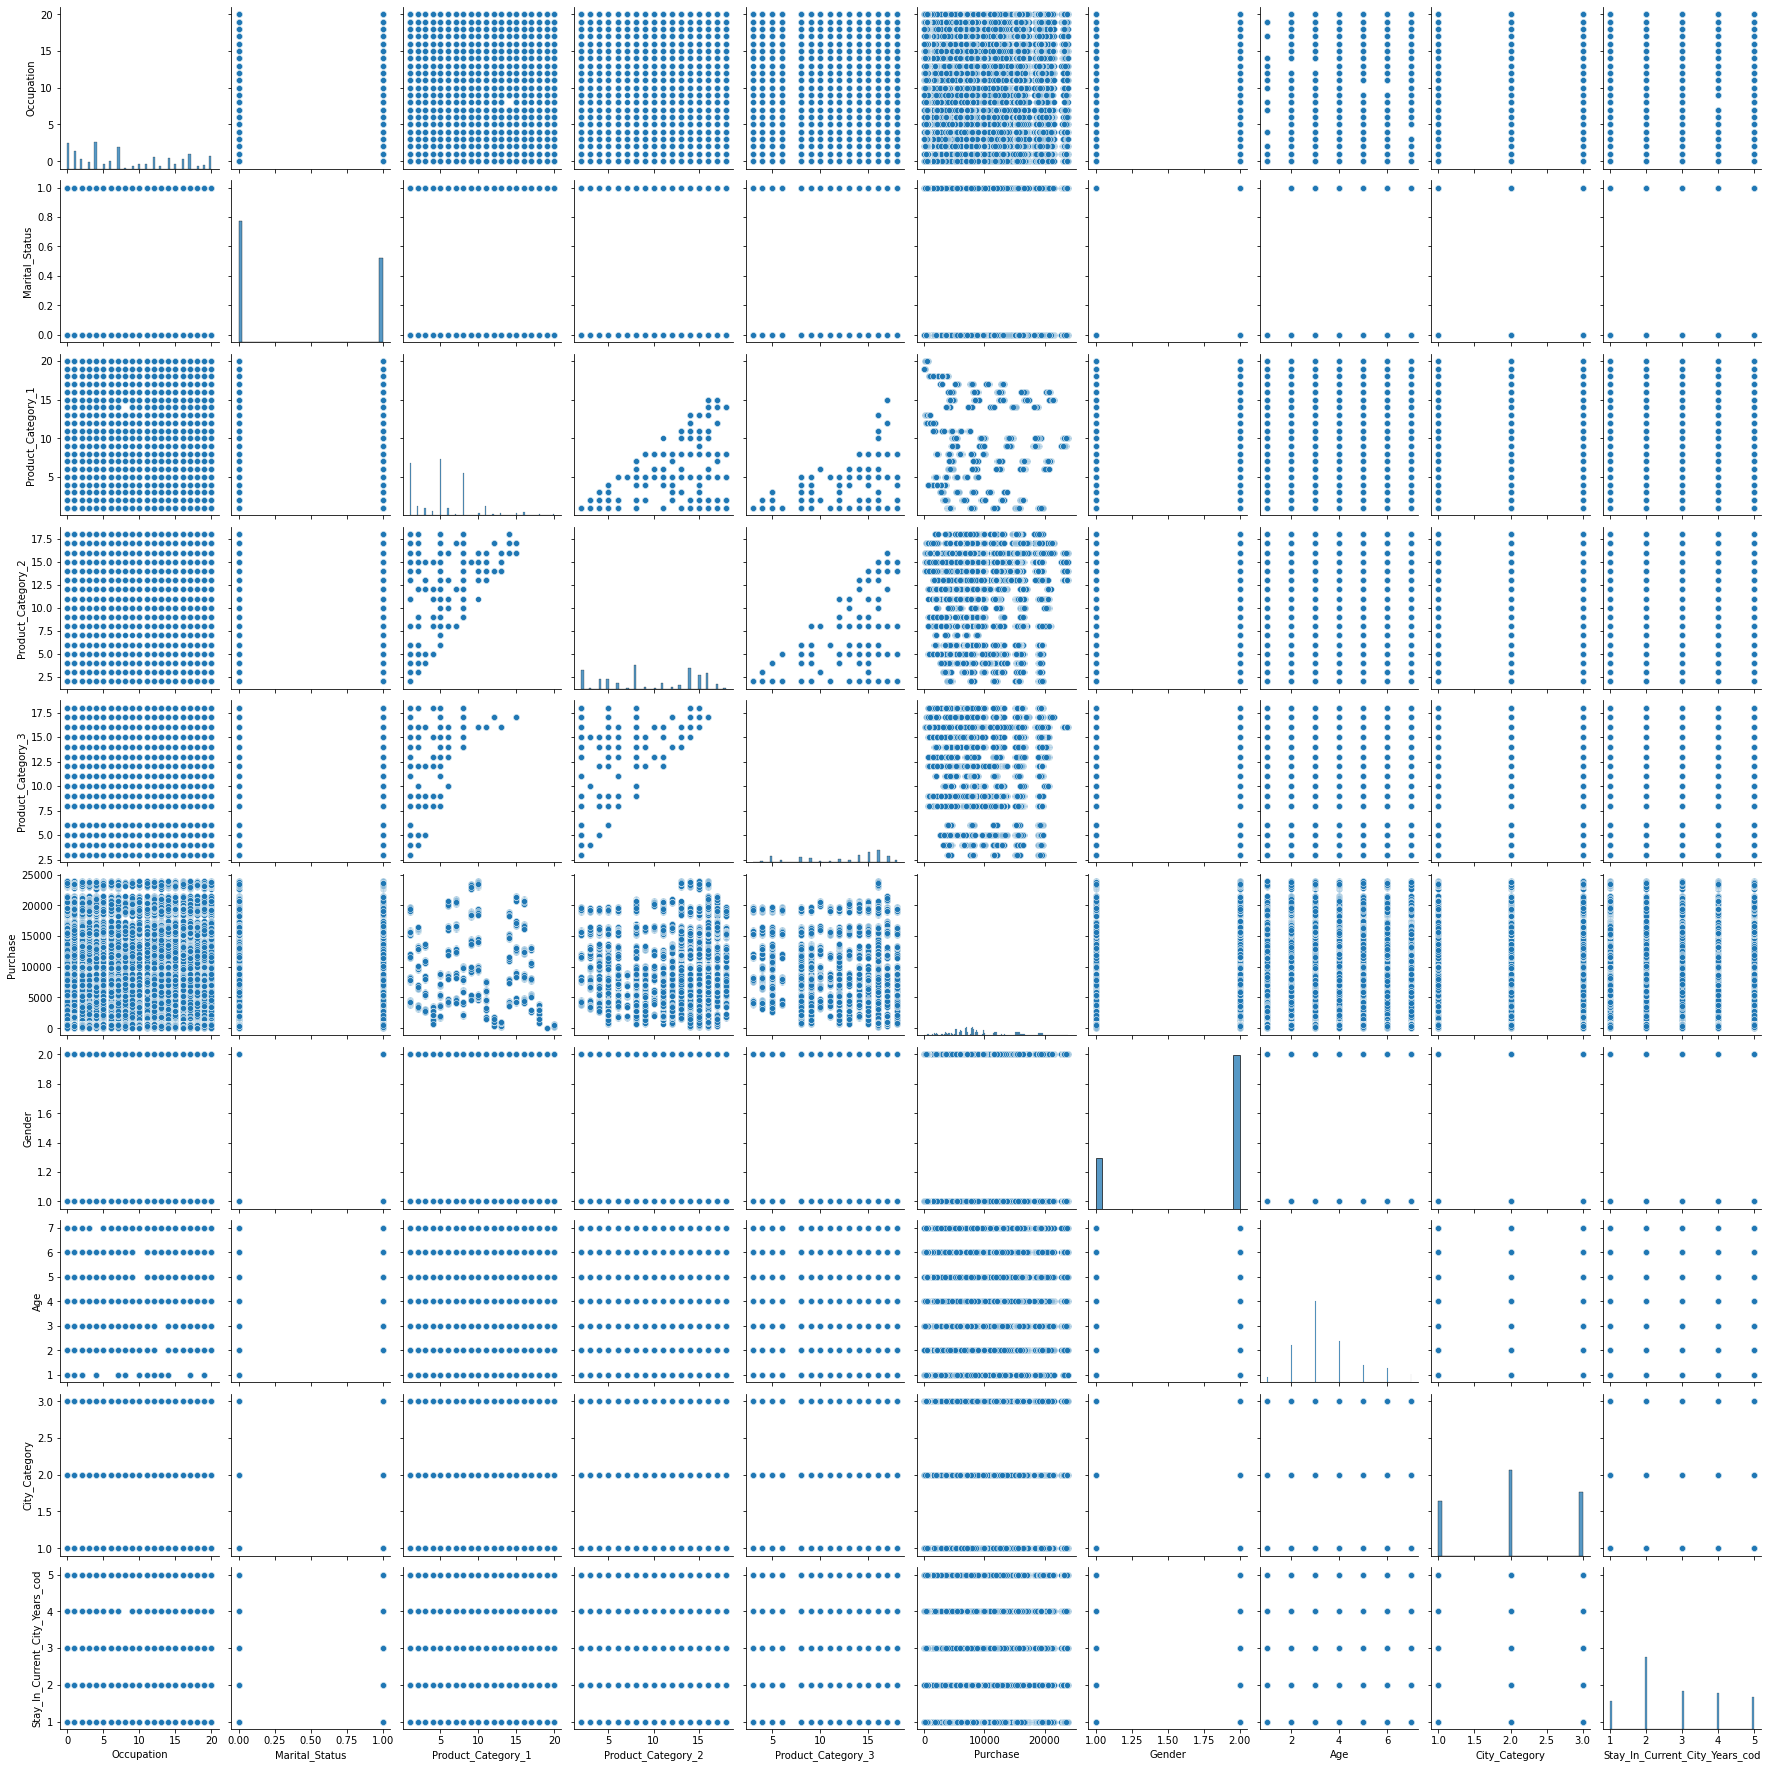

In [188]:
sns.pairplot(black_friday_new) 
plt.show()

_В нашо випадку це не дуже інформатвно ( хоч в цілому це досить зручно візуалізувати для задачі регресії).  
Для нашої задачі є сенс дивитися на графіки розсіювання між цільовою змінною та кожним признаком окремо (незалежна змінна)._

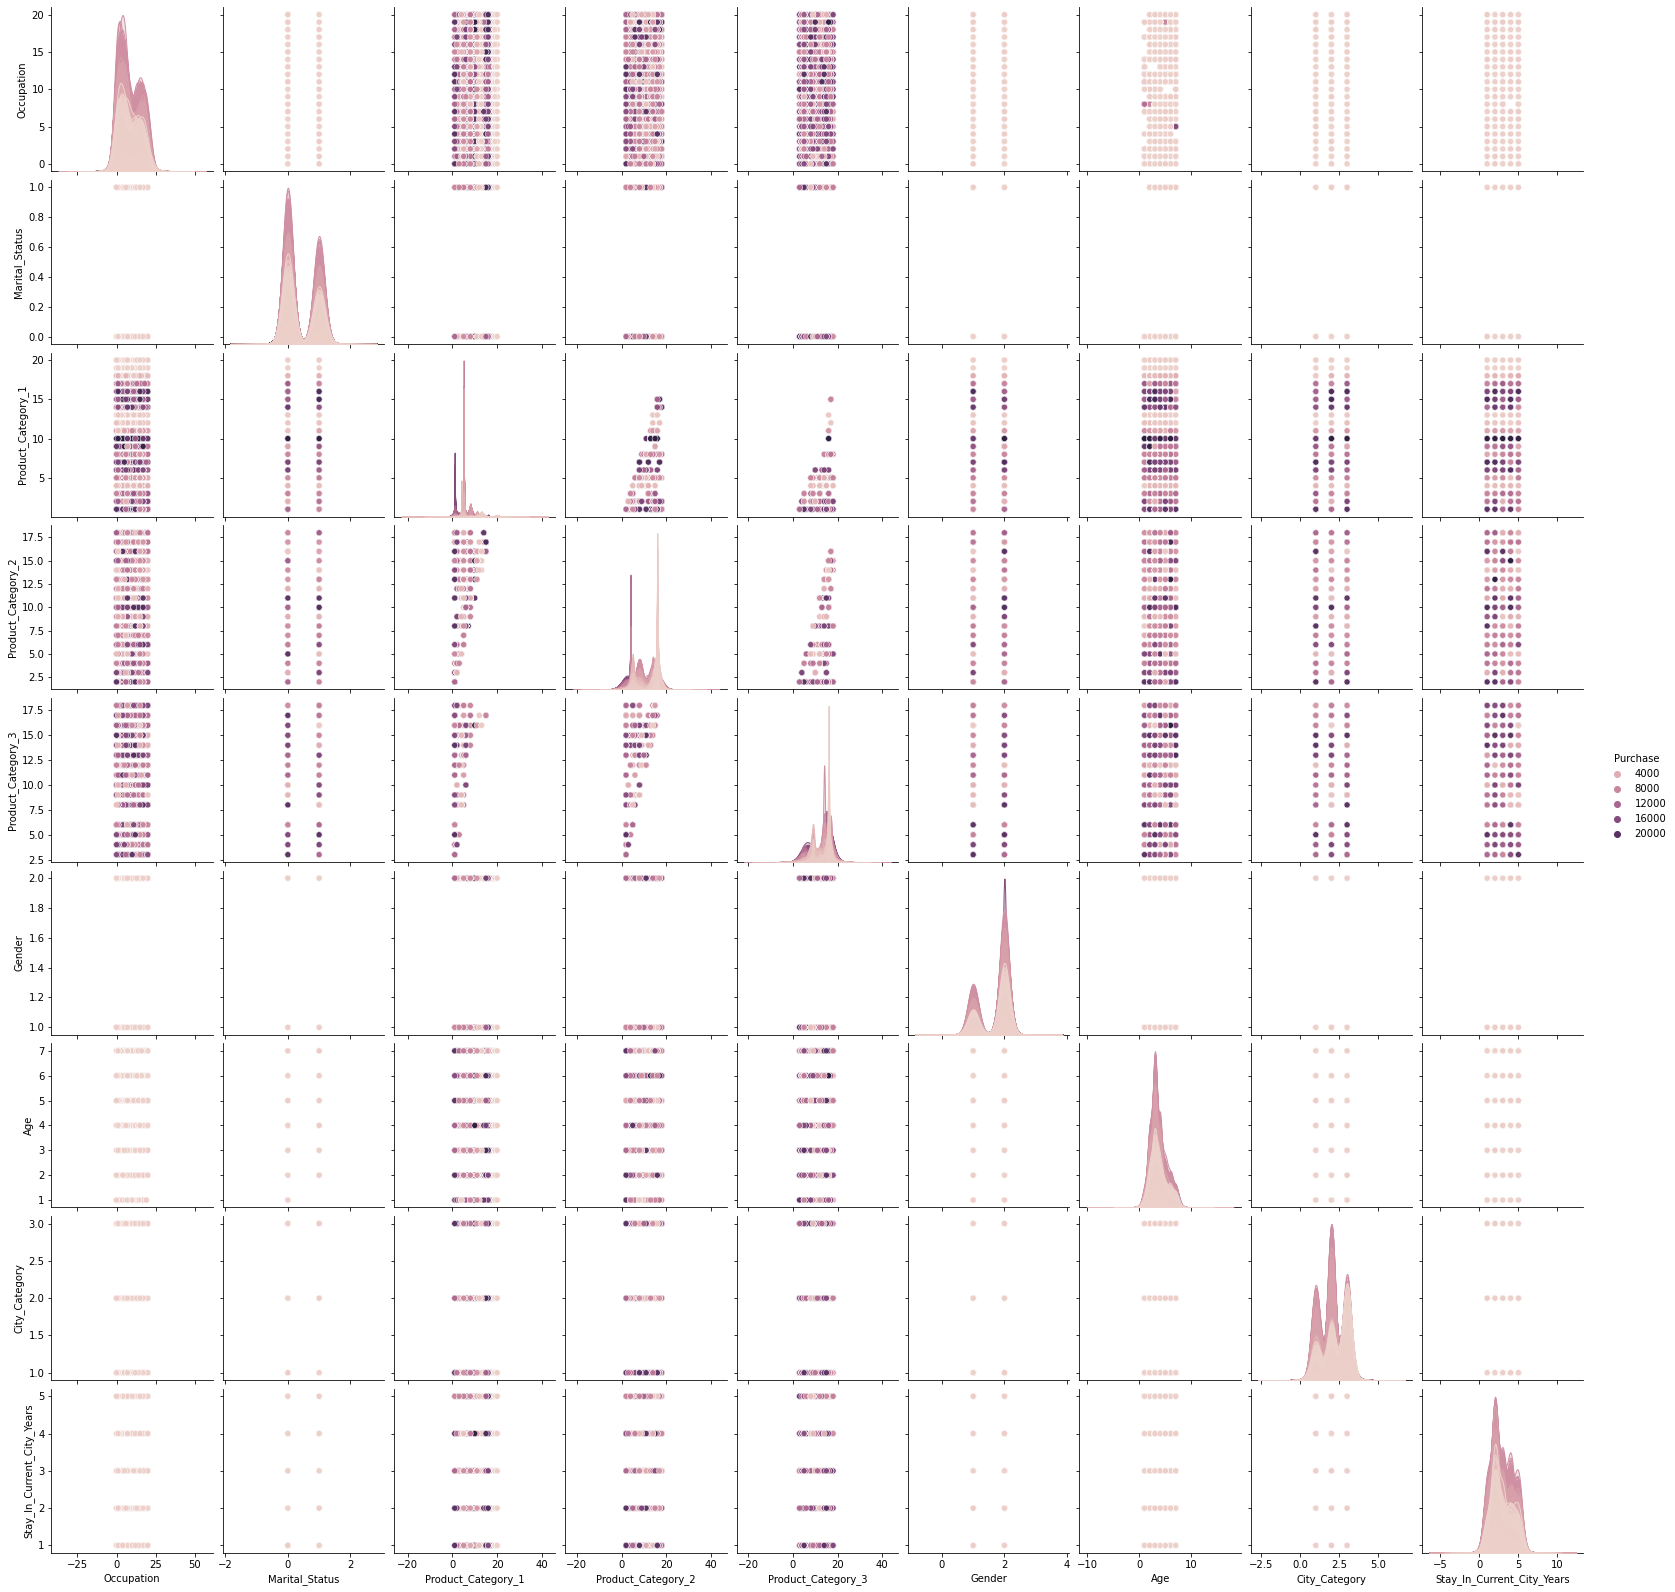

In [19]:
# Дуже довго виконується, оскільки достатсьо велику кількість місця займає  датасет (42.0 MB)
sns.pairplot(black_friday_new, hue='Purchase')
plt.show()   

_Для нашої задачі розділяємо кольором цільову змінну та інші на скатер-плоті,   
Інтенсивність кольру (від слабкішого до більш насиченого) по сумі покупок поділилась на 4000, 8000, 12000, 16000, 20000   
Перші Висновки, які можна зробити:_   
1. Найбільше покупок здійснили люди з професією "0", статтю "2"(тобто "М") та з сімейним станом "0";  
2. Якщо дивитись на вікову групу, то найбільше покупок здійснила вікова група 26-35 років, трохи менше групи 18-25 та 36-45, а найменше здійснювали покупки люди у віці 0-17 років та 55+ років;  
3. Якщо порівнювати найбільшу кількість порупок по категорії міст, то найбільше зробили з категорії "В", з категорії "С" на другому місці і трохи менше з категорії "А";  
4. Цікавим є факт того, що люди, які перебувають у поточному місці 1-2 роки - здійснюють найбільше покупок, а ті хто перебуває близько 4-х років - роблять менше покупок.

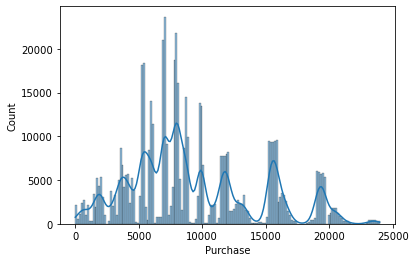

In [20]:
sns.histplot(black_friday_new['Purchase'], kde=True)
plt.show()

_Крім того, на графіку histplot видно, що дані мають не рівномірний розподіл._

## >Ряд візуалізацій, що характеризують різні показники окремо 

### Кругові діаграми

#### Підготовка даних

In [242]:
df1 = black_friday_new.groupby('Occupation').size()
df2 = black_friday_new.groupby('Gender').size()
df3 = black_friday_new.groupby('Age').size()
df4 = black_friday_new.groupby('City_Category').size()

#### Побудова кругових діаграм

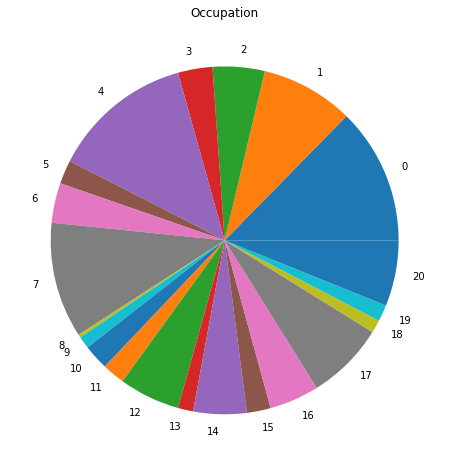

In [243]:
df1.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title('Occupation')
plt.ylabel("")
plt.show()

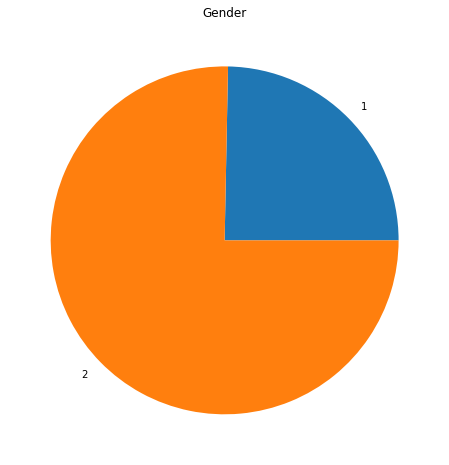

In [244]:
df2.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title('Gender')
plt.ylabel("")
plt.show()

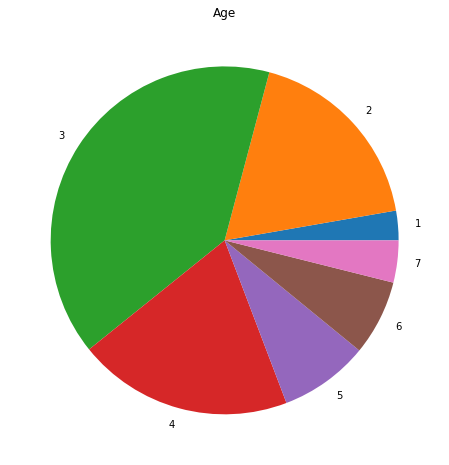

In [245]:
df3.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title('Age')
plt.ylabel("")
plt.show()

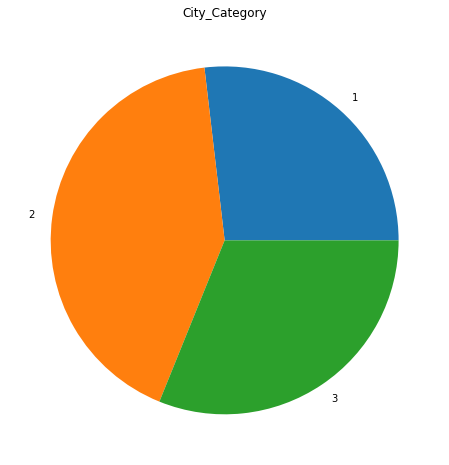

In [246]:
df4.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title('City_Category')
plt.ylabel("")
plt.show()

_Цікавим є те, що по професіям та по категоріям міст розподіл даних +/- рівний, а от за гендерною приналежність 3/4 мають перевагу люди "2" (чоловіки), крім того, більше 3/4 людей здійснювали покупки у віці 18-45 років._

### Теплова карта з допомогою Сіборновського "heatmap"

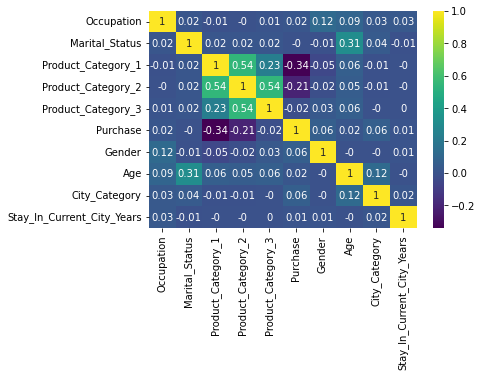

In [145]:
sns.heatmap(black_friday_new.corr().round(2), annot=True, cmap='viridis')
plt.show()

_Теплова карта кореляції показує приблизно те ж саме, що і графіки розсіювання (скатерплоти). Порахована кореляція Пірсона показує лінійну залежність, бачимо що найбільша кореляція (0,54) становлять пари даних 'Product_Category_1' - 'Product_Category_2' та  'Product_Category_2' - 'Product_Category_3'._
_Якщо ж говорити про конкретні пари змінних, то звертає на себе увагу пара 'Age' та 'Marital_Statuss' (кореляція 0,31), всі решта пар мають мінімальну кореляцію або не мають її._

### Побудова графіків за допомогою Сіборновського "jointplot"

##### Відображення тенденції між змінними 'Product_Category_1' та 'Product_Category_2', 'Product_Category_1' та 'Product_Category_3', 'Product_Category_2' та 'Product_Category_3'.

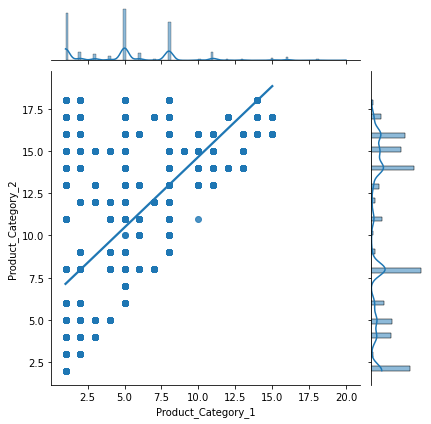

In [83]:
sns.jointplot(x = 'Product_Category_1', y = 'Product_Category_2', data = black_friday_new,  kind='reg')
plt.show()

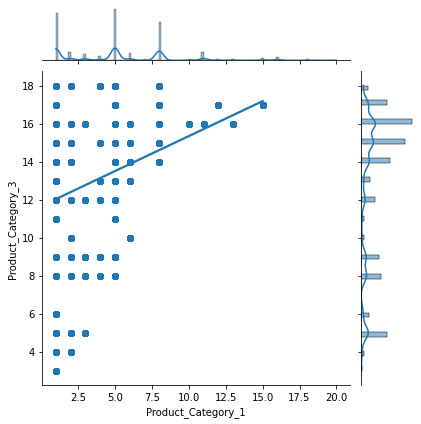

In [84]:
sns.jointplot(x = 'Product_Category_1', y = 'Product_Category_3', data = black_friday_new,  kind='reg')
plt.show()

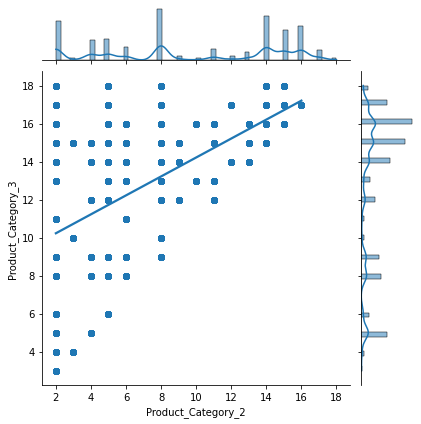

In [85]:
sns.jointplot(x = 'Product_Category_2', y = 'Product_Category_3', data = black_friday_new,  kind='reg')
plt.show()

_Результатом візуалізацій є відображення як два порівнювальні признаки змінюються по відношенню один до одного._

##### Відображення тенденцій між цільовою змінною (target) та признаками.

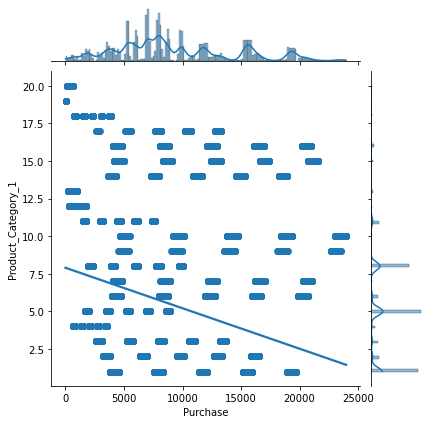

In [86]:
sns.jointplot(x = 'Purchase', y = 'Product_Category_1', data = black_friday_new,  kind='reg')
plt.show()

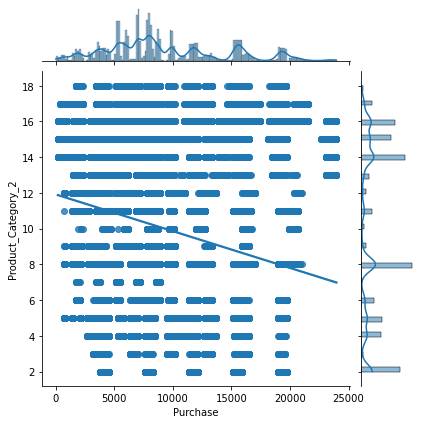

In [87]:
sns.jointplot(x = 'Purchase', y = 'Product_Category_2', data = black_friday_new,  kind='reg')
plt.show()

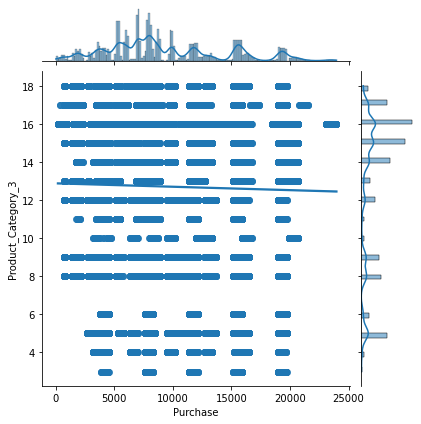

In [88]:
sns.jointplot(x = 'Purchase', y = 'Product_Category_3', data = black_friday_new,  kind='reg')
plt.show()

_Можна сказати, що цільова зміна має певну залежність до признаків продуктів категорій._

### За допомогою Сіборновського "countplot"

<AxesSubplot:xlabel='Purchase', ylabel='count'>

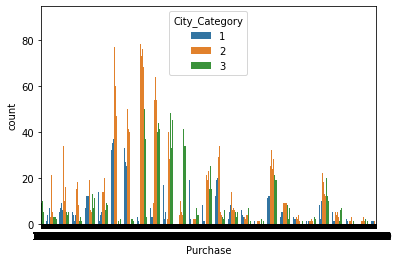

In [21]:
sns.countplot(x="Purchase", data=black_friday_new, hue="City_Category")
#дозволяє побудувати стовпчкову діаграму, де по hue розділяємо датасет по групам і порівняти результати

_Підтверджується, що найбільшу кількість порупок в залежності від категорії міст, то найбільше зробили з категорії "В", з категорії "С" на другому місці і трохи менше з категорії "А"._

<AxesSubplot:xlabel='Gender', ylabel='count'>

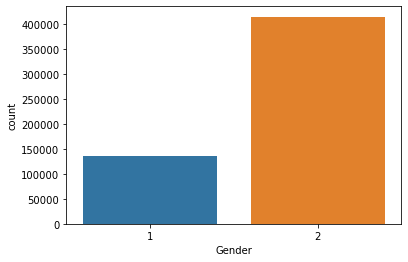

In [22]:
sns.countplot(x="Gender", data=black_friday_new)
#показує розділення за статтю

_Дана візуалізація демонструє, що найбільше покупок здійснювали люди за гендерною приналежністю до "М" (чоловіки)._

<AxesSubplot:xlabel='Marital_Status', ylabel='count'>

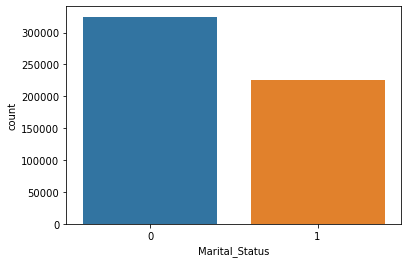

In [19]:
sns.countplot(x="Marital_Status", data=black_friday_new)
#показує розділення за сімейним станом 

_Дана візуалізація демонструє, що найбільше покупок здійснювали люди за сімейним станом "1"_

<AxesSubplot:xlabel='Occupation', ylabel='count'>

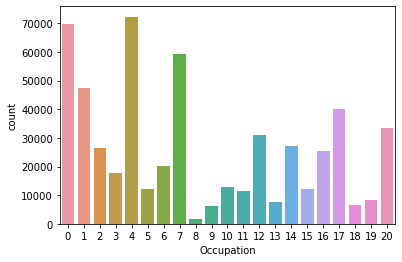

In [146]:
sns.countplot(x="Occupation", data=black_friday_new)
#дозволяє порівняти показники за професією

_Дана візуалізація демонструє, що найбільше покупок здійснювали люди за професіями "0", "4", "7"_

#### Статистика покупок по  Категорії міст (A,B,C) 

<AxesSubplot:xlabel='City_Category', ylabel='count'>

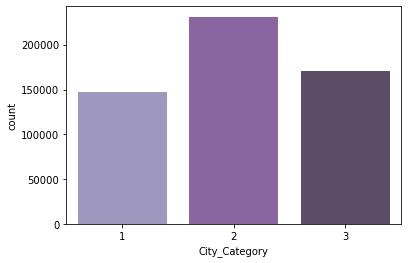

In [147]:
sns.countplot(x="City_Category", data=black_friday_new, palette="BuPu_d")
#показує розділення за категорією міса 

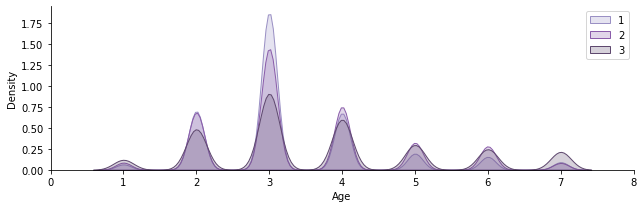

In [26]:
fg = sns.FacetGrid(black_friday_new, hue="City_Category", aspect=3, palette="BuPu_d")
fg.map(sns.kdeplot, "Age", shade=True)
fg.set(xlim=(0, 8))
plt.legend()
# Показує розділення за категорією міста у різних вікових групах

_Дані візуалізації демонструють, що вцілому найбільше покупок здійснювали люди з 2-ї категорії міста у вікових групах "26-35 років","18-25" та "36-45"._

<AxesSubplot:xlabel='City_Category', ylabel='count'>

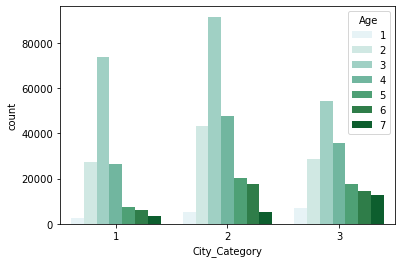

In [121]:
sns.countplot(x="City_Category", data=black_friday_new, hue="Age", palette="BuGn")#;

_З даного графіка також видно, що найбільші покупки у кожній категорії міста здійснювали люди 3ї (26-35 років) вікової групи._

<AxesSubplot:xlabel='Age', ylabel='count'>

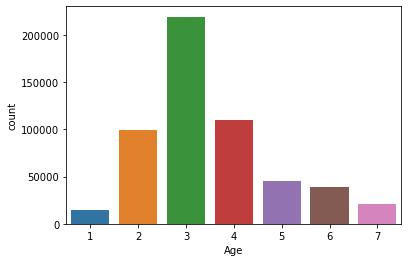

In [28]:
sns.countplot(x="Age", data=black_friday_new)
#показує розділення за віком

<AxesSubplot:xlabel='Age', ylabel='Density'>

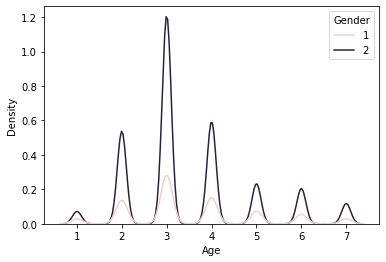

In [122]:
sns.kdeplot(x='Age', hue='Gender', data=black_friday_new, shade=False)
#дві щільності, які демонструють розділення по віку та по статі

_Дані візуалізації демонструють, що вцілому найбільше покупок здійснювали люди у вікових групах "26-35 років","18-25" та "36-45", при чому найбільше покупок здійснювали люди за гендерною приналежністю до "М" (чоловіків)._

### Цікавим буде подивитись відношення покупок по віку з розбивкою по статі за допомогою Сіборновського "lmplot"        

_Поле стать є досить важливм для прогнозування тих, хто найбільше здійснює покупки._

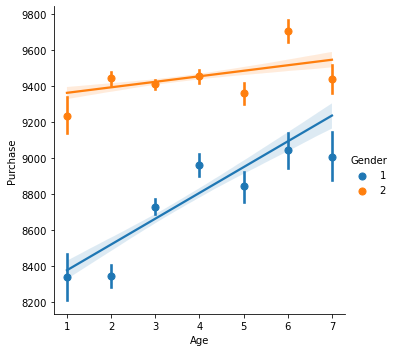

In [32]:
age_bins = [1, 2, 3, 4, 5, 6, 7]
sns.lmplot(x="Age", y="Purchase", data=black_friday_new, hue="Gender", x_bins=age_bins)

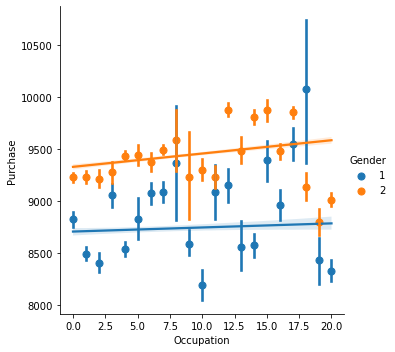

In [33]:
age_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sns.lmplot(x="Occupation", y="Purchase", data=black_friday_new, hue="Gender", x_bins=age_bins)

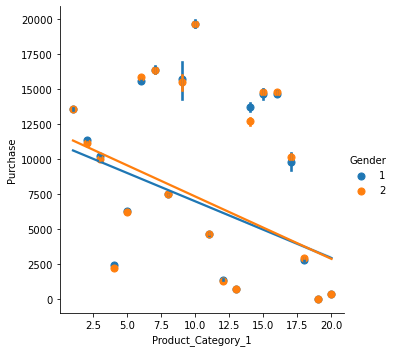

In [34]:
age_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sns.lmplot(x="Product_Category_1", y="Purchase", data=black_friday_new, hue="Gender", x_bins=age_bins)

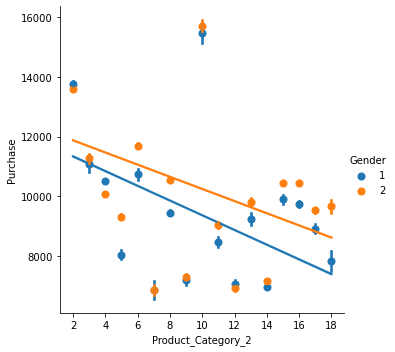

In [35]:
age_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sns.lmplot(x="Product_Category_2", y="Purchase", data=black_friday_new, hue="Gender", x_bins=age_bins)

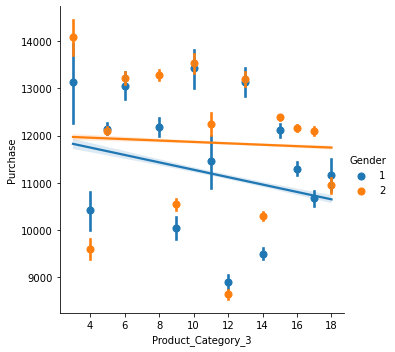

In [36]:
age_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sns.lmplot(x="Product_Category_3", y="Purchase", data=black_friday_new, hue="Gender", x_bins=age_bins)

_Висновками може бути, те, що дійсно стать впливає на кількість тих, хто здійснює більше покупок.  
З усіх графіків видно, що люди зі статтю "2" переважають._ 

### Стовпчкова діаграма здійснення покупок людей розділених за гендерною приналежністю в залежності від вікової групи

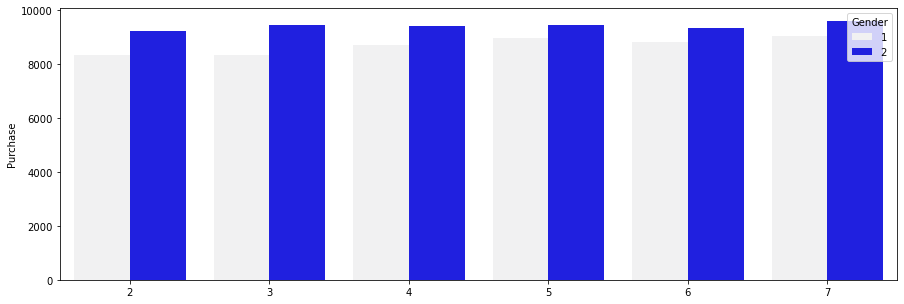

In [38]:
age_step = 1
plt.figure(figsize=(15, 5))
sns.barplot(x=np.digitize(black_friday_new['Age'], bins=range(0, 7, age_step))*age_step, 
            y=black_friday_new['Purchase'], 
            hue=black_friday_new['Gender'], 
            estimator=np.mean, 
            color='blue',
            ci=None)
plt.show()

_Як бачимо з даних діаграм, розділення покупок по віковим групам з розділенням на статті всеодно вказує на більшу кількість зі статтю "2"._

## >Попередня обробка даних перед побудовою прогнозної моделі

### Обробка відсутнього значення

##### Перегляд кількості NaN та інших значень

In [148]:
black_friday_new['Product_Category_2'].value_counts(dropna=False)

NaN     173638
8.0      64088
14.0     55108
2.0      49217
16.0     43255
15.0     37855
5.0      26235
4.0      25677
6.0      16466
11.0     14134
17.0     13320
13.0     10531
9.0       5693
12.0      5528
10.0      3043
3.0       2884
18.0      2770
7.0        626
Name: Product_Category_2, dtype: int64

In [149]:
black_friday_new['Product_Category_3'].value_counts(dropna=False)

NaN     383247
16.0     32636
15.0     28013
14.0     18428
17.0     16702
5.0      16658
8.0      12562
9.0      11579
12.0      9246
13.0      5459
6.0       4890
18.0      4629
4.0       1875
11.0      1805
10.0      1726
3.0        613
Name: Product_Category_3, dtype: int64

In [150]:
# Ще раз виведення пропцентного співвідношення пропущених значень в колонках
black_friday_new.isna().sum().div(black_friday.shape[0]).mul(100).round(2)

Occupation                     0.00
Marital_Status                 0.00
Product_Category_1             0.00
Product_Category_2            31.57
Product_Category_3            69.67
Purchase                       0.00
Gender                         0.00
Age                            0.00
City_Category                  0.00
Stay_In_Current_City_Years     0.00
dtype: float64

_Бачимо,що замінювати NaN у стовпчиках "Product_Category_2" та "Product_Category_3" модою (значеннями, що найчастіше зустріячаються) є не зовсім правильним, якщо відкинути таку кількість рядків (31,5% та майже 70%), то це може дуже вплинути на майбутню модель._  
_Тому залишається замінити або медіаною (для невеликих наборів даних) або середнім арефметичним (для велих наборів даних), так як у нас великий набор даних, то замінюємо на  середнє арефметичне._

### Заповнення значень NaN

In [151]:
black_friday_new2=black_friday_new.fillna(black_friday_new.mean(), axis=0)
black_friday_new2

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender,Age,City_Category,Stay_In_Current_City_Years
0,10,0,3,9.842329,12.668243,8370,1,1,1,3
1,10,0,1,6.000000,14.000000,15200,1,1,1,3
2,10,0,12,9.842329,12.668243,1422,1,1,1,3
3,10,0,12,14.000000,12.668243,1057,1,1,1,3
4,16,0,8,9.842329,12.668243,7969,2,7,3,5
...,...,...,...,...,...,...,...,...,...,...
550063,13,1,20,9.842329,12.668243,368,2,6,2,2
550064,1,0,20,9.842329,12.668243,371,1,3,3,4
550065,15,1,20,9.842329,12.668243,137,1,3,2,5
550066,1,0,20,9.842329,12.668243,365,1,7,3,3


In [152]:
#Можна пересвідчитись, що пропущених значень нема
black_friday_new2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Occupation                  550068 non-null  int64  
 1   Marital_Status              550068 non-null  int64  
 2   Product_Category_1          550068 non-null  int64  
 3   Product_Category_2          550068 non-null  float64
 4   Product_Category_3          550068 non-null  float64
 5   Purchase                    550068 non-null  int64  
 6   Gender                      550068 non-null  int64  
 7   Age                         550068 non-null  int64  
 8   City_Category               550068 non-null  int64  
 9   Stay_In_Current_City_Years  550068 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 42.0 MB


## >ПОБУДОВА ПРОГНОЗНОЇ МОДЕЛІ

#### Розбиття датасету на тестві та трейнові дані та їх тренування 

In [153]:
X0 = black_friday_new2[
    [
    'Occupation',
  'Marital_Status',
  'Product_Category_1',
  'Product_Category_2',
  'Product_Category_3',
  'Gender',
  'Age',
  'City_Category',
  'Stay_In_Current_City_Years'
      ]
]
y0 = black_friday_new2['Purchase']

In [154]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)

In [155]:
X0_train.shape

(440054, 9)

#### Cтворення моделі Лінійної регресії

In [156]:
reg = LinearRegression()

#### Навчання моделі

In [252]:
reg.fit(X0_train, y0_train)

LinearRegression()

#### R^2 на трейнових даних

In [158]:
reg.score(X0_train, y0_train)

0.12875973083219228

#### R^2 на тестових даних

In [159]:
reg.score(X0_test, y0_test)

0.128014575672166

_З результатів метрики R^2 видно, що значення майже однакові, що вказує на майже ідеальний баланс даних на трейні та тесті._

#### Оцінка крефіцієнтів по признакам

In [160]:
reg.coef_

array([   6.19201925,  -57.22304989, -407.89973163,  -84.70442373,
         78.12160939,  508.66704455,  117.3720602 ,  345.65488474,
          7.62722415])

In [161]:
reg.intercept_

9258.285700818642

In [162]:
df_coef = pd.DataFrame(reg.coef_, X.columns, columns=['Коефіцієнти моделі'])
df_coef

,Коефіцієнти моделі
Occupation,6.192019
Marital_Status,-57.223050
Product_Category_1,-407.899732
Product_Category_2,-84.704424
Product_Category_3,78.121609
Gender,508.667045
Age,117.372060
City_Category,345.654885
Stay_In_Current_City_Years,7.627224


_Такі результати показують коєфіцієнт важливості кожного з признаків._

#### Оцінка метрик

In [163]:
y0_pred = reg.predict(X0_train)
y0_pred

array([10998.98936197,  9776.24497826,  8244.26785899, ...,
        8830.92916479,  7281.26014695,  8089.69736871])

In [164]:
y0_test_pred = reg.predict(X0_test)
y0_test_pred

array([12837.61123887, 10582.59707841,  7003.65383199, ...,
        8073.03879009,  6803.62546825,  9749.55543709])

#### Виведення середньої абсолютної похибки

In [253]:
print(mean_absolute_error(y0_train, y0_pred))
print(mean_absolute_error(y0_test, y0_test_pred))
#менша цифра на тесті вказує на кращий результат

3592.534280971242
3587.0837582016597


_По результату видно, що на тесті результат кращий ніж на трейні._

#### Виведення МSE (середній квадрат)

In [166]:
print(mean_squared_error(y0_train, y0_pred))
print(mean_squared_error(y0_test, y0_test_pred))

22005213.4443472
21909662.68101039


#### Виведення кореня від МSE

In [167]:
print(np.sqrt(mean_squared_error(y0_train, y0_pred)))
print(np.sqrt(mean_squared_error(y0_test, y0_test_pred)))

4690.971481937105
4680.775863146023


#### Виведення відсоткової похибки MAPE

In [168]:
print(mean_absolute_percentage_error(y0_train, y0_pred) * 100)
print(mean_absolute_percentage_error(y0_test, y0_test_pred) * 100)

112.05636835112074
114.58073089848514


_По результату видно, що на тесті результат кращий ніж на трейні, але похибка є достатньо великою._

### Виведення результат прогнозу для випадкових значень

In [247]:
reg.predict(np.array([10, 1, 1, 2.0, 3.0, 1, 1, 1, 1]).reshape(1, -1))

C:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([9899.36030615])

##### Як бачимо можна підставляти значення у майбутньому та прогнозувати суму покупки на нових даних.

### Побудова моделі лінійної регресії з різними регуляризаціями

#### Побудова моделі лінійної регресії з регуляризацією Ridge

In [170]:
reg_Ridge = Ridge(alpha=0.1, fit_intercept=True)

reg_Ridge.fit(X0_train, y0_train)

print(reg_Ridge.score(X0_train, y0_train))
print(reg_Ridge.coef_)
print(reg_Ridge.intercept_)

0.1287597308321895
[   6.19202485  -57.22298246 -407.89972856  -84.70442456   78.12160778
  508.66641307  117.3720435   345.65474813    7.62722734]
9258.287075675935


#### Побудова моделі лінійної регресії з регуляризацією Lasso

In [171]:
reg_Lasso = Lasso(alpha=0.1, fit_intercept=True)

reg_Lasso.fit(X0_train, y0_train)

print(reg_Lasso.score(X0_train, y0_train))
print(reg_Lasso.coef_)
print(reg_Lasso.intercept_)


0.12875972533776348
[   6.19591709  -56.71941832 -407.89823808  -84.69580161   78.09898996
  508.13249664  117.26827292  345.49185356    7.5731825 ]
9260.02924337771


#### Побудова моделі лінійної регресії з регуляризацією ElasticNet

In [172]:
reg_ElasticNet = ElasticNet(alpha=0.1, fit_intercept=True) 

reg_ElasticNet.fit(X0_train, y0_train)

print(reg_ElasticNet.score(X0_train, y0_train))
print(reg_ElasticNet.coef_)
print(reg_ElasticNet.intercept_)

0.12865308570617073
[   7.18480988  -44.78023212 -407.07505313  -84.86485599   77.64740017
  399.38458035  113.99678901  318.03588605    8.13411066]
9506.712493768664


_Як бачимо по результатам моделі лінійної регресії з різними регуляризаціями, то майже однакові результати показали регуляризації Ridge та Lasso, трохи кращі результати при регуляризації ElasticNet._ 

### Виведення основних метрик основної моделі    

In [173]:
def calculate_metrics(y0_pred, y0_test_pred):
    return {'r2': r2(y0_pred, y0_test_pred).round(3), 
            'rmse': np.sqrt(mse(y0_pred, y0_test_pred)).round(3), 
            'mae': mae(y0_pred, y0_test_pred).round(3), 
            'mape': (mape(y0_pred, y0_test_pred)*100).round(3)}

In [174]:
calculate_metrics(y0_test, reg.predict(X0_test))

{'r2': 0.128, 'rmse': 4680.776, 'mae': 3587.084, 'mape': 114.581}

In [175]:
df_comparison = pd.DataFrame(columns=['r2', 'rmse', 'mae', 'mape'])

In [176]:
metrics = calculate_metrics(y0_test, reg.predict(X0_test))

df_comparison = df_comparison.append(metrics, ignore_index=True)
df_comparison

C:\Users\BU400A\AppData\Local\Temp\ipykernel_7528\2656720926.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comparison = df_comparison.append(metrics, ignore_index=True)


,r2,rmse,mae,mape
0,0.128,4680.776,3587.084,114.581


### Виведення основних метрик основної моделі з регуляризаціями

#### Ridge

In [177]:
calculate_metrics(y0_test, reg_Ridge.predict(X0_test))

{'r2': 0.128, 'rmse': 4680.776, 'mae': 3587.084, 'mape': 114.581}

In [178]:
metrics = calculate_metrics(y0_test, reg_Ridge.predict(X0_test))

df_comparison = df_comparison.append(metrics, ignore_index=True)
df_comparison

C:\Users\BU400A\AppData\Local\Temp\ipykernel_7528\1342497761.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comparison = df_comparison.append(metrics, ignore_index=True)


,r2,rmse,mae,mape
0,0.128,4680.776,3587.084,114.581
1,0.128,4680.776,3587.084,114.581


#### Lasso

In [179]:
calculate_metrics(y0_test, reg_Lasso.predict(X0_test))

{'r2': 0.128, 'rmse': 4680.776, 'mae': 3587.075, 'mape': 114.581}

In [180]:
metrics = calculate_metrics(y0_test, reg_Lasso.predict(X0_test))

df_comparison = df_comparison.append(metrics, ignore_index=True)
df_comparison

C:\Users\BU400A\AppData\Local\Temp\ipykernel_7528\196993398.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comparison = df_comparison.append(metrics, ignore_index=True)


,r2,rmse,mae,mape
0,0.128,4680.776,3587.084,114.581
1,0.128,4680.776,3587.084,114.581
2,0.128,4680.776,3587.075,114.581


#### ElasticNet

In [181]:
calculate_metrics(y_test, reg_ElasticNet.predict(X_test))

{'r2': 0.13, 'rmse': 4690.395, 'mae': 3592.962, 'mape': 114.285}

In [182]:
metrics = calculate_metrics(y_test, reg_ElasticNet.predict(X_test))

df_comparison = df_comparison.append(metrics, ignore_index=True)
df_comparison

C:\Users\BU400A\AppData\Local\Temp\ipykernel_7528\162420226.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comparison = df_comparison.append(metrics, ignore_index=True)


,r2,rmse,mae,mape
0,0.128,4680.776,3587.084,114.581
1,0.128,4680.776,3587.084,114.581
2,0.128,4680.776,3587.075,114.581
3,0.13,4690.395,3592.962,114.285


##### Таблиця з усіма метрками до моделі без регуляризації та з ними

_Виходячи з результатів метрик можна зробити висновок, що регуляризація покращили лише трохи якість моделі, найкраще покращення при ElasticNet. В подальшому при побудові моделі досліджуватимемо метрику "r2"._

## >Побудова основної моделі на основі інших алгоритмів машинного навчання 

#### Розбиття датасету на тестві та трейнові дані та їх тренування ще раз 

In [183]:
X = black_friday_new2[
    [
    'Occupation',
  'Marital_Status',
  'Product_Category_1',
  'Product_Category_2',
  'Product_Category_3',
  'Gender',
  'Age',
  'City_Category',
  'Stay_In_Current_City_Years'
      ]
]
y = black_friday_new2['Purchase']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [185]:
X_train.shape

(412551, 9)

In [186]:
X = black_friday_new2.drop(columns=['Purchase'])
y = black_friday_new2['Purchase']

In [187]:
X.shape

(550068, 9)

### Побудова  прогнозної моделі за допомогою алгоритму "Дерево рішень"

In [188]:
model = DecisionTreeRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model.fit(X_train, y_train)

DecisionTreeRegressor()

In [189]:
model.score(X_test, y_test)

0.555696776493618

_Первинний результат моделі на тесті є 0.55, що вказує на доволі низьку якість моделі._

In [190]:
r2 = cross_val_score(estimator=DecisionTreeRegressor (max_depth=15), X=X, y=y, scoring='r2', cv=5)
print(r2)
print(r2.mean())

[0.63449639 0.6334507  0.63438056 0.63504002 0.66164727]
0.6398029889936666


_Результат моделі на крос-валідації при параметрі "max_depth=15" є набагато кращим - 0.64, що вказує на покращення якості моделі._

#### Перевірка модеді "Дерева рішень" при різних аргументах "max_depth" від 1 до 30 з метою знаходження оптимального результату моделі

In [137]:
for i in range(1, 31):
    m = DecisionTreeRegressor(max_depth=i)
    r2 = cross_val_score(estimator=m, X=X, y=y, scoring='r2', cv=5)
    print(i, '\t', r2.mean())

1 	 0.2690598797605782
2 	 0.28699449328323723
3 	 0.4450546927591792
4 	 0.47193066643524706
5 	 0.5343976179003445
6 	 0.5907472641339061
7 	 0.645062206194924
8 	 0.6479909285164325
9 	 0.6504803060101759
10 	 0.6512676249485139
11 	 0.6513528605796532
12 	 0.6500507649883808
13 	 0.6481017391685716
14 	 0.6442554672953108
15 	 0.6397502328938997
16 	 0.6336035870517501
17 	 0.626246153511262
18 	 0.617162640145988
19 	 0.6076525994268003
20 	 0.5986386516043704
21 	 0.58974709865284
22 	 0.5819074383536049
23 	 0.5749787757268134
24 	 0.5701082400497329
25 	 0.5655273254792382
26 	 0.5625953802765296
27 	 0.5607553963494711
28 	 0.5592004526527636
29 	 0.55835628318274
30 	 0.5583146990941062


_Бачимо, що чим складніший алгритм (з кожним кроком), тим усереднена якість моделі зростає. Найкращий результат моделі виявлено при параметрі "max_depth", значення якого дорівнює 10-11, а після значення 11 наступає перенавчання моделі і якість моделі починає знижуватись.  
Крім того, характерним є те, що модель навчалась доволі швидко, а після максимального навчання, відбувається її перенавчання і швидке зниження якості моделі._

#### Інтерпретація (візуалізація) результатів моделі "дерева рішень"

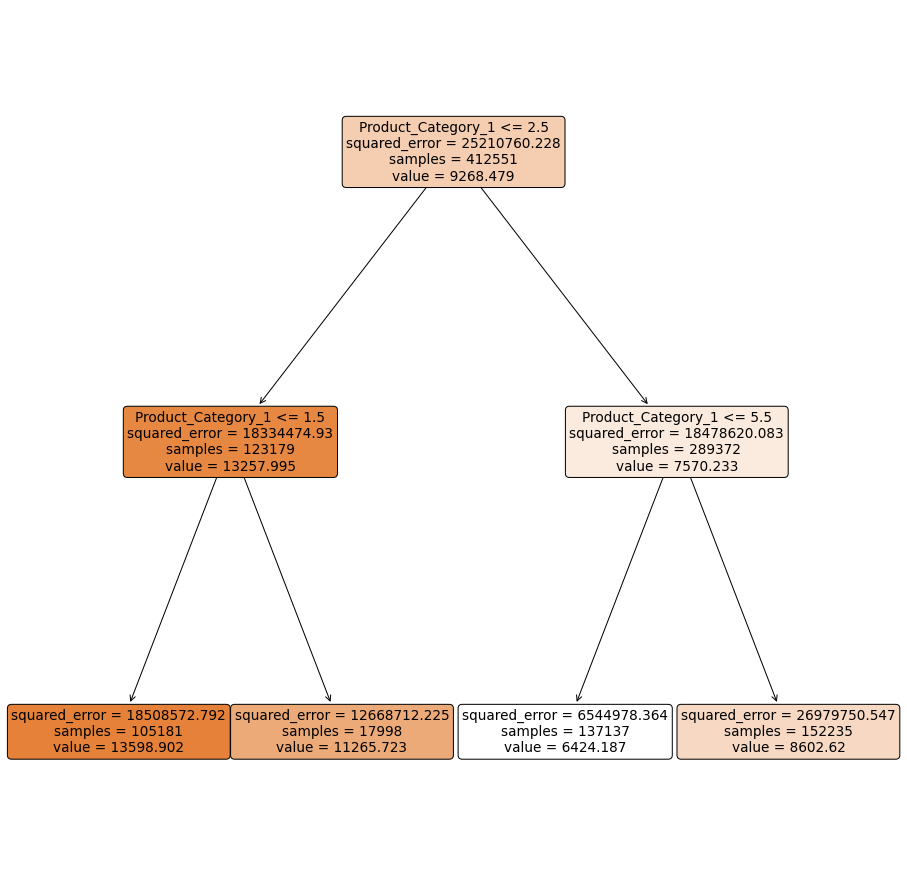

In [191]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train)

plt.figure(figsize=(16,16))
plot_tree(model, feature_names=X.columns, filled=True,  rounded=True)
plt.show()

_Висновки: при дереві з 2=х кроків, бачимо, що розділення відбувається по Product_Category_1 менше/дорівнює 2.5, а далі знову по Product_Category_1 менше/дорівнює 1.5 та 5.5, дане вказує на те, що дані стопчика Product_Category_1 є основними у нашій моделі._

## Побудова альтернативної прогнозної моделі без колонок "Product_Category_2" та "Product_Category_3"

#### Розбиття датасету на тестві та трейнові дані та їх тренування ще раз

In [192]:
X1 = black_friday_new2[
    [
    'Occupation',
  'Marital_Status',
  'Product_Category_1',
   'Gender',
  'Age',
  'City_Category',
  'Stay_In_Current_City_Years'
      ]
]
y1 = black_friday_new2['Purchase']

In [193]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1)

In [194]:
X1_train.shape

(412551, 7)

In [195]:
X1 = black_friday_new2.select_dtypes(exclude='float64').drop(columns=['Purchase'])
y1 = black_friday_new2['Purchase']

In [196]:
X1.shape

(550068, 7)

### Побудова  альтернативної прогнозної моделі "Дерево рішень"

In [197]:
model_alter = DecisionTreeRegressor()

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1)

model_alter.fit(X1_train, y1_train)

DecisionTreeRegressor()

In [198]:
model_alter.score(X1_test, y1_test)

0.6499954613657686

_Первинний результат альтернативної моделі на тесті є майже 0.65, що значно краще за результат на тесті основної моделі._

In [199]:
r2_X1 = cross_val_score(estimator=DecisionTreeRegressor (max_depth=15), X=X1, y=y1, scoring='r2', cv=5)
print(r2_X1)
print(r2_X1.mean())

[0.64165604 0.64415352 0.64421662 0.64525758 0.6710927 ]
0.6492752910285334


_Результат альтернативної моделі на крос-валідації при параметрі "max_depth=15" майже такий самий як і на тесті, що вказує на сталу якість альтернативної моделі._

#### Перевірка альтернативної модеді "Дерева рішень" при різних аргументах "max_depth" від 1 до 30 з метою знаходження оптимального результату моделі

In [147]:
for i in range(1, 31):
    m1 = DecisionTreeRegressor(max_depth=i)
    r2_X1 = cross_val_score(estimator=m1, X=X1, y=y1, scoring='r2', cv=5)
    print(i, '\t', r2_X1.mean())

1 	 0.2690598797605782
2 	 0.28699449328323723
3 	 0.44468268990882515
4 	 0.4705927328968622
5 	 0.5312487857779853
6 	 0.5850262883576259
7 	 0.6378180373258905
8 	 0.6397605223587306
9 	 0.641119929221398
10 	 0.6427863031387939
11 	 0.6443564831469726
12 	 0.6457389826266764
13 	 0.6471565054511241
14 	 0.6483437223005545
15 	 0.649229718724645
16 	 0.6495338327049834
17 	 0.649685227384406
18 	 0.6496016322303549
19 	 0.6490732661265467
20 	 0.6484740337744571
21 	 0.6478968840569277
22 	 0.6475905503161086
23 	 0.6473781080281832
24 	 0.6472847809235235
25 	 0.6472780133670961
26 	 0.6471650725120897
27 	 0.6472299994154536
28 	 0.6472126219655474
29 	 0.6472431300234918
30 	 0.6473497596621515


_Бачимо, що найкращий результат альтернативної моделі виявлено при параметрі "max_depth", значення якого дорівнює 17, а після значення 17 наступає перенавчання моделі і якість моделі починає знижуватись.  
Крім того, характерним є те, що усереднений результат якості моделі так і не досяг результату 0.65, що в кінцевому результаті вказує на те, що якість альтернативної моделі не краще за основну модель._

#### Інтерпретація (візуалізація) результатів альтернативної моделі "дерева рішень"

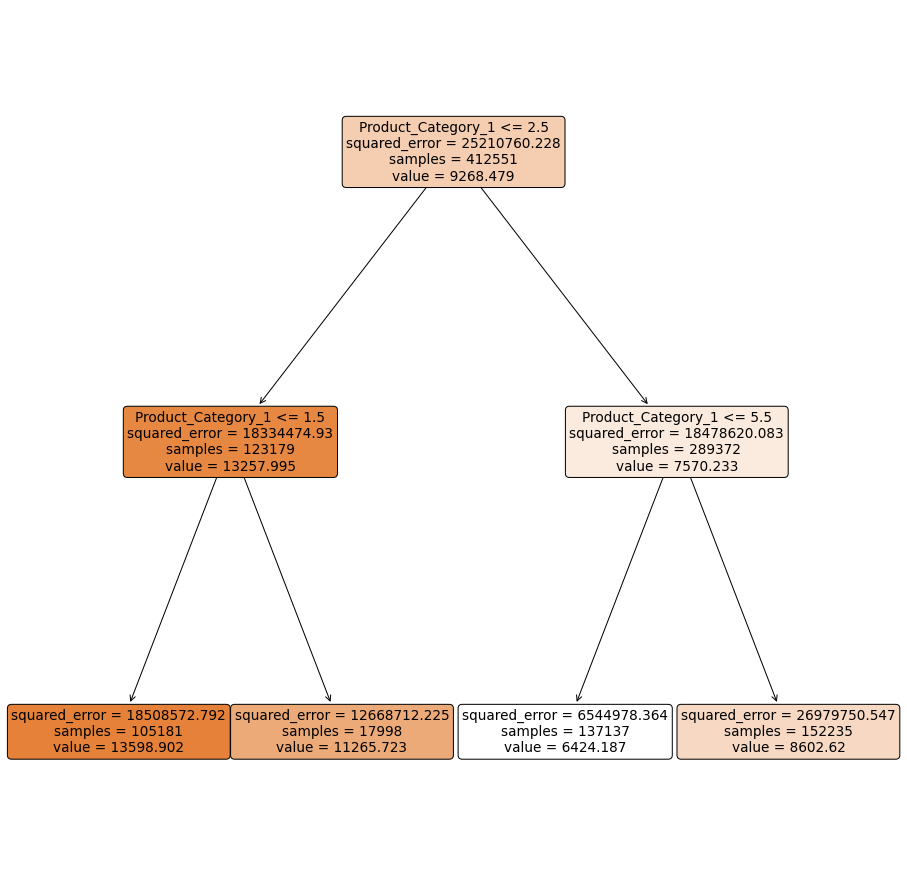

In [200]:
model_alter = DecisionTreeRegressor(max_depth=2)
model_alter.fit(X1_train, y1_train)

plt.figure(figsize=(16,16))
plot_tree(model_alter, feature_names=X1.columns, filled=True,  rounded=True)
plt.show()

_Висновки альтернативної моделі: при дереві з 2=х кроків, бачимо, що розділення відбувається також по Product_Category_1 менше/дорівнює 2.5, а далі знову по Product_Category_1 менше/дорівнює 1.5 та 5.5, дане вказує на те, що дані стопчика Product_Category_1 є основними у нашій моделі. Другим висновком є те, що відсутність стовпчиків Product_Category_2 та Product_Category_3 не впливає на якість моделі, тому нема сенсу в подальшому працювати з альтернативною моделлю._

## Побудова основної моделі за допомогою алгоритму "Випадкового лісу дерев рішень"

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

RandomForestRegressor()

In [202]:
model_1.score(X_test, y_test)

0.6319682486286992

_Первинний результат моделі на тесті є 0.63, що суттєво не змінило якість моделі._

In [168]:
r2_1 = cross_val_score(estimator=model_1, X=X, y=y, scoring='r2', cv=5)
print(r2_1)
print(r2_1.mean())

[0.6223316  0.62370856 0.62665147 0.62496655 0.65397896]
0.6303274293790799


_Результат моделі на крос-валідації майже такий самий, як і на тесті, що вказує на сталу якість моделі на даному алгоритмі._

#### Перевірка модеді "Випадкового лісі Дерев рішень" при різних аргументах "max_depth" від 1 до 100 з метою знаходження оптимального результату моделі

In [160]:
# Примітка: Виконується доволі довго
for i in range(1, 102, 5):
    model_1 = RandomForestRegressor(n_estimators=i, random_state=1)
    r2_1 = cross_val_score(estimator=model_1, X=X, y=y, scoring='r2', cv=5)
    print(i, '\t', r2_1.mean())


1 	 0.5178816549183537
6 	 0.6127439106563596
11 	 0.6211685548349621
16 	 0.6242194550657704
21 	 0.6257752751356657
26 	 0.6267658983200366
31 	 0.6275624729308449
36 	 0.628019341553686
41 	 0.6283934803472025
46 	 0.6287642344288074
51 	 0.6289723780914198
56 	 0.6291966150584652
61 	 0.6293817448754488
66 	 0.6295443182775096
71 	 0.6296852121097769
76 	 0.6298125308313832
81 	 0.6298542055966276
86 	 0.629950721188308
91 	 0.6300352609763502
96 	 0.6301177573371189
101 	 0.6301952902085002


_При перевірці усередненої  якості моделі "Випадкового лісу дерев рішень", виявлено, що із збільшенням кількості дерев якість моделі постійно зростає, без перенавчання, при чому, що після 5 дерев якість моделі суттєво збільшилась, а в подальшому якість моделі збільшується лише на соті та тисячні._  
_Крім того, висновком є те, що результат моделі при алгоритмі "Випадковий ліс дерева рішень" виявився гірший ніж при алгоритмі "Дерево рішень"._

## Побудова основної моделі за допомогою алгоритму  ансамблю моделей "Stacking"

In [203]:
model = DecisionTreeRegressor()
model_1 = RandomForestRegressor()

model_stack = StackingRegressor(estimators=[('DecisionTreeRegressor', model),
                                   ('RandomForestRegressor', model_1)])

In [204]:
model_stack

StackingRegressor(estimators=[('DecisionTreeRegressor',
                               DecisionTreeRegressor()),
                              ('RandomForestRegressor',
                               RandomForestRegressor())])

In [205]:
model_stack.fit(X_train, y_train)

StackingRegressor(estimators=[('DecisionTreeRegressor',
                               DecisionTreeRegressor()),
                              ('RandomForestRegressor',
                               RandomForestRegressor())])

In [206]:
model_stack.score(X_test, y_test)

0.6382022063658951

In [216]:
# Примітка: Виконується доволі довго
r2_stack = cross_val_score(estimator=model_stack, X=X, y=y, scoring='r2', cv=5)
print(r2_stack)
print(r2_stack.mean())

[0.59202598 0.62954236 0.63214526 0.63111409 0.65565079]
0.6280956971227116


_Висновок: при побудові ансамблю з 2-х побудованих раніше моделей ('DecisionTreeRegressor', 'RandomForestRegressor') та створення нової моделі (StackingRegressor) результат моделі на кросвалідації став приблизно таким самим, оскільки модель ("Stacking") не просто усереднювала результати, а і удосконалила нашу модель._

## Побудова основної моделі за допомогою алгоритму  ансамблю моделей "XGBoost"

In [208]:
xgb_reg = xgb.XGBRegressor()

In [209]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [210]:
xgb_reg.score(X_test, y_test)

0.6747044709806367

In [211]:
r2_xgb_reg = cross_val_score(estimator=xgb_reg, X=X, y=y, scoring='r2', cv=5)
print(r2_xgb_reg)
print(r2_xgb_reg.mean())

[0.66442387 0.66577172 0.66645756 0.66484869 0.6886566 ]
0.6700316862255458


_Висновок: при побудові основної моделі за допомогою алгоритму  ансамблю моделей "XGBoost" результат моделі на кросвалідації став найкращим, оскільки модель ("XGBoost") є більш складнішим алгоритмом і в кінечному результаті удосконалила нашу модель._

#### Перевірка моделі "XGBoost" при різних аргументах "max_depth" від 1 до 200 з метою знаходження оптимального результату моделі

In [215]:
# Примітка: Виконується доволі довго
for i in range(1, 201, 10):
    xgb_reg = xgb.XGBRegressor(n_estimators=i, max_depth=3, random_state=1)      
    r2_xgb_reg = cross_val_score(estimator=xgb_reg, X=X, y=y, scoring='r2', cv=5)
    print(i, '\t', r2_xgb_reg.mean())

1 	 -1.4510482471396615
11 	 0.6160866076069661
21 	 0.6382609752941744
31 	 0.6447061076201026
41 	 0.6476776393077502
51 	 0.6494337983803637
61 	 0.6510100144047636
71 	 0.652286466078905
81 	 0.6533807137581171
91 	 0.6540317834038367
101 	 0.6547255137962112
111 	 0.6552973189020184
121 	 0.6557218702508923
131 	 0.6560768646902833
141 	 0.6564649809126046
151 	 0.6567938258566213
161 	 0.6571182415286192
171 	 0.6574405140591144
181 	 0.6577301521346424
191 	 0.6579471779806527


_При перевірці усередненої  якості моделі "XGBoost", виявлено, що із збільшенням кількості дерев якість моделі постійно зростає, без перенавчання, при чому, на 1му дереві алгоритм по суті видав відємний результат (слабке дерево), після 6 та 11 дерев явне зростання якості моделі (перевіряв з кроком 5 також), а в подальшому якість моделі збільшується лише на соті та тисячні._  
_Крім того, висновком є те, що результат моделі при алгоритмі "XGBoost" виявився кращим ніж при попередіх  алгоритмах._

### Оцінка кожного признаку окремо (числові результати) для прогнозування моделі при використанні  алгоритму "XGBoost"

In [212]:
xgb_reg.feature_importances_

array([0.00513909, 0.00465741, 0.92892534, 0.01703303, 0.01875175,
       0.00433971, 0.00567607, 0.01058134, 0.0048963 ], dtype=float32)

_Бачимо, що визначальним (з величезною різницею від інших) є признак 'Product_Category_1' (майже 0,93), другими по важливості є признаки 'Product_Category_2' та 'Product_Category_3' (приблизно по 0,18), а третім по важливості є признак 'City_Category' (0,01), всі решта признаків мають приблизно однакову важливість (приблизно по 0,005)._

### Перевірка кількості зустрічань признаків в деревах при алгоритмі "XGBoost"

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

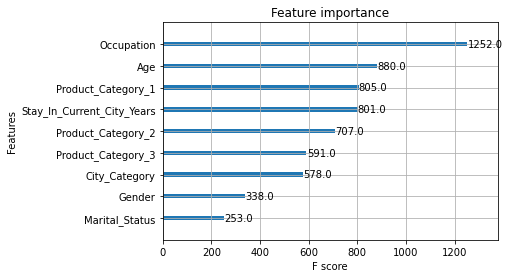

In [213]:
xgb.plot_importance(xgb_reg)

_Бачимо скільки разів кожний признак зустрічається в деревах, виходить, що найчастіше зустрічється признак "Occupation" (1252 рази), признак "Age" зустрічається майже на третину менше (880 разів), інші важливі признаки "Product_Category_1" та "Stay_In_Current_City_Years" зустрічаються по 800 разів, а найменш зустрічаючим признаком є "Marital_Status" (253 рази)._

## > Порівняння результатів всіх моделей (оцінка якості моделі)

In [217]:
for mod in [model, model_1, model_stack, xgb_reg]: 
    r2_all = cross_val_score(estimator=mod, X=X, y=y, scoring='r2', cv=5)
    print(r2_all)
    print(r2_all.mean())

[0.54704298 0.54923554 0.55349246 0.55213291 0.58684949]
0.5577506757673342
[0.62237027 0.62326883 0.62668989 0.62499043 0.65378574]
0.6302210288222156
[0.62867907 0.62969529 0.63230525 0.63108975 0.6105733 ]
0.6264685306297644
[0.65224112 0.65285256 0.65361843 0.65340197 0.67762181]
0.6579471779806527


###### Порівнюючи результати всіх моделей('DecisionTreeRegressor','RandomForestRegressorr', 'StackingRegressor', 'XGBRegressor'), можна зробити висновок, що найкращий результат (якість моделі ~ 0,66) вийшов в моделі 'XGBRegressor', моделі 'RandomForestRegressorr', 'StackingRegressor' показали трохи гірший результата (якість моделі ~ 0,62), а найгірший результат (якість моделі ~ 0,56) показала наша модель при 'DecisionTreeRegressor'. 

# ВИСНОВОК

###### Кінцевим висновком може бути те, що для даного набору даних найкращий результат дозволить показати побудова моделі за допомогою алгоритму  ансамблю моделей "XGBoost". 
### Даючи відповідь на питання: "Чи може бути застосована дана модель на практиці?", то можна відповісти, що результат моделі (66%) в майбутньому залажатиме від конкретних даних в признаках, зокрема, в признаку "Product_Category_1" і в цілому може бути використаний для застосування в практичній діяльності, що в майбутньому допоможе створити персоналізовану пропозицію для клієнтів щодо різних продуктів.
